
# A Gentle Introduction to SHapley Additive exPlanations (SHAP)

SHAP (an acronym for SHapley Additive exPlanations) is a way to explain the predictions of a machine learning model, introduced by Lundberg and Lee in 2017 [1].

This tutorial gives a gentle introduction to SHAP explanations of machine learning predictions, without too much technical detail.

 * SHAP is a *local* explanation method - it gives an explanation for why a model made a *specific* prediction, rather than trying to explain the overall or general behaviour of a model.

 * SHAP is a *model-agnostic* explanation method - it can be used to explain the predictions of *any* machine learning model that takes inputs and predicts outputs, rather than being limited to one type of model.



# Some background about SHAP

The explanations from SHAP take the form of numbers called *Shapley values*. These are named after [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley) (1923 - 2016), a mathematician who won the 2012 Nobel prize in economics for their invention.

![Lloyd Shapley - image from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/c/cb/Shapley%2C_Lloyd_%281980%29.jpg)

Shapley was interested in the problem of how to fairly reward parties who collaborate together on a project.

Later (in 2017), Lundberg and Lee noticed that the same ideas about fairly rewarding parties who collaborate can be applied to understand machine learning models.

There is some math involved in the computation, but the interpretation and intution of SHAP values is simple: **SHAP values measure how much a dataset feature contributed to model's prediction being different from the average model prediction.**

For instance;

 * A large positive SHAP value for some feature 'A' indicates that feature 'A' helped push the model's prediction a lot higher than the avearge model prediction.
 * On the other hand, a small negative SHAP value for a feature 'B' means that feature 'B' helped push the model's prediction a little bit lower than the average model prediction.

We can also add up the SHAP values for all the features, and arrive at the model's actual prediction (which is where the 'additive' part of the name comes from).




# A hands-on example - predicting red wine ratings

We will now look at an example of using SHAP to explain some predictions from a Machine Learning model.

Below, click the 'Play' icon beside each cell to run the code step by step as you work through the example.


First, we need to install and import some software libraries. This should only take a few seconds to run.

In [ ]:

#@title Install and import software libraries
!pip install shap itables > /dev/null

# IO so we can read our 'CSV file' from a string
import io

# Pandas for tabular data manipulation
import pandas as pd

# Numpy for numeric processing
import numpy as np

# Matplotlib and Seaborn for pretty plots
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks')

# ITables for pretty tables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

# A simple machine learning model
from lightgbm import LGBMRegressor



## Loading a dataset

We will use a toy dataset (an extract of the Kaggle [Wine Rating and Price dataset](https://www.kaggle.com/datasets/budnyak/wine-rating-and-price)), which contains information about 100 different red wines.

Below, we load the data and print it in a table.


In [ ]:

red_wine_csv_file = """Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.0,2011
Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.5,2017
Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016
Gigondas (Nobles Terrasses) 2017,France,Gigondas,Vieux Clocher,3.7,100,19.9,2017
Marion's Vineyard Pinot Noir 2016,New Zealand,Wairarapa,Schubert,4.0,100,43.87,2016
Red Blend 2014,Chile,Itata Valley,Viña La Causa,3.9,100,17.52,2014
Chianti 2015,Italy,Chianti,Castello Montaùto,3.6,100,10.75,2015
Tradition 2014,France,Minervois,Domaine des Aires Hautes,3.5,100,6.9,2014
Chianti Riserva 2013,Italy,Chianti,Poggiotondo,3.9,100,20.95,2013
Descendant 2016,Australia,Barossa,Torbreck,4.3,100,140.64,2016
Les Obriers de la Peira Terrasses du Larzac 2017,France,Terrasses du Larzac,La Pèira en Damaisèla,4.1,100,14.52,2017
Zenas Primitivo 2018,Italy,Puglia,La Bollina,3.6,100,9.26,2018
Cuvée Confidence Côtes du Rhône Rouge 2017,France,Côtes-du-Rhône,Domaine Fond Croze,3.7,100,8.49,2017
Shiraz 2018,Australia,South Eastern Australia,Barramundi,3.2,100,6.5,2018
Proprietor's Blend 2016,South Africa,Stellenbosch,Ernie Els,4.2,100,29.09,2016
La Bienquerida 2016,Spain,Bierzo,Losada,4.3,100,41.58,2016
Cabernet Sauvignon 2015,United States,California,Hacienda,3.8,100,7.95,2015
Fulgeo Negroamaro Salento 2016,Italy,Salento,San Donaci,4.0,100,12.9,2016
Contraste Tinto 2015,Portugal,Douro,Conceito,3.4,100,9.9,2015
Steiner 2013,Hungary,Sopron,Weninger,3.7,100,24.5,2013
Old Vines Primitivo 2015,Italy,Puglia,Azienda Agricola Morella,4.2,100,38.7,2015
Virtus Tannat 2013,Brazil,Serra Gaúcha,Monte Paschoal,2.9,100,6.77,2013
Kallista 2015,South Africa,Stellenbosch,Vriesenhof,4.3,100,26.25,2015
Badia a Passignano Gran Selezione Chianti Classico 2016,Italy,Chianti Classico,Antinori,4.2,1000,39.9,2016
Saint-Émilion Grand Cru (Premier Grand Cru Classé) 2012,France,Saint-Émilion Grand Cru,Château Figeac,4.4,1000,174.49,2012
Carlo V Il Rosso dell'Imperatore 2013,Italy,Veneto,Colli Vicentini,3.7,1000,15.9,2013
Pinot Noir 2016,United States,Monterey,District 7,3.6,1001,15.98,2016
Marquis de Calon Saint-Estèphe 2015,France,Saint-Estèphe,Château Calon-Ségur,3.9,1001,43.28,2015
Hécula Monastrell 2017,Spain,Yecla,Castaño,3.3,1004,8.83,2017
Berola 2015,Spain,Campo de Borja,Borsao,3.9,1006,14.52,2015
Saint-Julien (Grand Cru Classé) 2010,France,Saint-Julien,Château Léoville Poyferré,4.4,1008,189.0,2010
Pinot Noir Bourgogne 2017,France,Bourgogne,Faiveley,3.7,1009,15.9,2017
Vigna del Noce Barbera d'Asti 2007,Italy,Barbera d'Asti,Trinchero,4.1,101,76.9,2007
I Tratturi Rosso 2017,Italy,Salento,San Marzano,3.8,101,7.04,2017
Château Pilet Bordeaux 2017,France,Bordeaux,J.Queyrens & Fils,3.6,101,6.5,2017
Sancerre Rouge 2015,France,Sancerre,Comte Lafond,4.2,101,37.34,2015
Shiraz 2016,Australia,McLaren Vale,Food Truck,3.5,101,8.67,2016
Ro-Rée Saint-Joseph 2018,France,Saint-Joseph,Louis Chèze,4.2,101,24.37,2018
Cabernet Sauvignon 2015,South Africa,Stellenbosch,Big Flower,4.0,101,16.5,2015
Cuvée Alienor Fronsac 2015,France,Fronsac,Château Mayne-Vieil,3.7,101,16.47,2015
Sabbie di Sopra al Bosco 2014,Italy,Terre del Volturno,Nanni Copé,3.8,101,31.96,2014
Roma Rosso 2018,Italy,Lazio,Poggio le Volpi,4.0,101,9.95,2018
Garnacha de Arrayán 2014,Spain,Castilla y León,Arrayán,3.7,101,21.9,2014
Cabernet Sauvignon 2018,Chile,Central Valley,Valdivieso,3.3,101,7.6,2018
Terrenus Vinhas Velhas Reserva 2013,Portugal,Alentejano,Rui Reguinga,4.1,101,27.95,2013
Fronsac 2005,France,Fronsac,Château Villars,3.8,101,25.95,2005
Cuvée Charles de Batz Madiran 2014,France,Madiran,Domaine Berthoumieu,3.7,101,14.09,2014
Stony Terrace Cabernet Sauvignon 2016,United States,Napa Valley,Rutherford Wine Company,3.8,101,18.03,2016
12 e Mezzo Puglia Primitivo Organic Wine 2016,Italy,Puglia,Varvaglione,3.9,101,9.4,2016
El Abuelo Selección Edición Limitada 2013,Spain,Almansa,Bodegas Piqueras,4.2,101,10.95,2013
Sangre de Toro Special Selection 2017,Spain,Catalunya,Torres,3.6,101,8.9,2017
Château Paul Mas Coteaux du Languedoc Clos des Mures 2018,France,Languedoc,Paul Mas,3.8,101,11.05,2018
Merlot 2018,France,Pays d'Oc,Les Jamelles,3.6,101,5.36,2018
Roscaleto Barbera d'Alba 2015,Italy,Barbera d'Alba,Enzo Boglietti,3.9,101,31.18,2015
Barolo Cannubi 2014,Italy,Barolo,Giacomo Fenocchio,4.0,101,39.9,2014
Pauillac (Premier Grand Cru Classé) 2017,France,Pauillac,Château Mouton Rothschild,4.6,101,633.62,2017
Cabernet Sauvignon 2014,United States,Washington,Stimson Estate Cellars,3.3,101,8.29,2014
Côte-Rôtie Le Gallet Blanc 2017,France,Côte-Rôtie,Francois Villard,4.4,101,48.0,2017
Capatosta 2015,Italy,Toscana,Poggio Argentiera,3.8,101,19.9,2015
Constance Madiran 2015,France,Madiran,Domaine Berthoumieu,3.8,101,9.5,2015
Oak Cask Malbec 2019,Argentina,Mendoza,Trapiche,3.7,1010,7.36,2019
Amancaya Malbec - Cabernet Sauvignon 2017,Argentina,Mendoza,Caro (Catena and Rothschild),4.0,1010,16.8,2017
Laccento Ruché di Castagnole Monferrato 2017,Italy,Ruchè,Montalbera,4.0,1012,19.9,2017
San Leonardo 2011,Italy,Vigneti delle Dolomiti,San Leonardo,4.3,1012,48.64,2011
Fausto Tannat 2015,Brazil,Serra Gaúcha,Pizzato,3.6,1012,11.35,2015
Pauillac (Grand Cru Classé) 2007,France,Pauillac,Château Pichon Baron,4.4,1014,119.0,2007
Disciples 2016,United States,Napa Valley,The Crane Assembly,4.3,1014,53.61,2016
Zinfandel 2015,United States,Mendocino County,Bonterra,3.6,1015,16.75,2015
Margaux 2010,France,Margaux,Château Labégorce,4.0,1016,40.95,2010
La Luna e i Falò Barbera d'Asti Superiore 2015,Italy,Barbera d'Asti,Vite Colte,3.8,1016,11.49,2015
Ribera del Duero 2015,Spain,Ribera del Duero,Garmón,4.2,1017,38.8,2015
Les Jardins Rouge 2018,France,Faugères,Saint Antonin,3.8,102,7.95,2018
Nero d'Avola - Syrah 2018,Italy,Terre Siciliane,Roccaperciata,3.7,102,4.75,2018
La Bienquerida 2013,Spain,Bierzo,Losada,4.1,102,35.97,2013
Bonera 2018,Italy,Terre Siciliane,Mandrarossa,3.7,102,9.5,2018
Noi 4 Bolgheri 2016,Italy,Bolgheri,Tenuta dei Sette Cieli,4.0,102,23.5,2016
Pinot Noir 2016,New Zealand,Marlborough,Clos Henri Vineyard,3.9,102,27.78,2016
Saint-Émilion Grand Cru 2005,France,Saint-Émilion Grand Cru,Château Grand Barrail Lamarzelle Figeac,3.9,102,39.95,2005
Gran Selección Tempranillo 2017,Spain,Castilla,Viña San Juan,3.4,102,6.75,2017
Syrah 2017,South Africa,Paarl,Glen Carlou,3.9,102,18.25,2017
Zweigelt 2017,Austria,Burgenland,Judith Beck,3.9,102,10.6,2017
Saint-Émilion Grand Cru 2015,France,Saint-Émilion Grand Cru,Château Vieux Clos St. Emilion,4.1,102,23.09,2015
Listán Negro 2017,Spain,Lanzarote,Bermejo,3.6,102,17.95,2017
Viile Metamorfosis Merlot 2015,Romania,Dealu Mare,Vitis Metamorfosis,3.5,102,7.5,2015
Merlot - Cabernet Sauvignon - Petit Verdot 2014,South Africa,Walker Bay,Creation,3.9,102,12.48,2014
RWT Shiraz 2017,Australia,Barossa Valley,Penfolds,4.4,102,229.0,2017
Fronton 2018,France,Fronton,Château Bellevue La Forét,3.5,102,6.95,2018
Costers Del Gravet Montsant 2013,Spain,Montsant,Capçanes,3.7,102,13.95,2013
Merlot 2018,Italy,Terre Siciliane,Cusumano,3.4,102,7.9,2018
Pinot Noir 2015,Austria,Burgenland,Paul Achs,3.7,102,33.05,2015
Coume de l'Olla Rouge 2019,France,Vin de France,Matassa,4.1,102,16.96,2019
Schwarzer 2017,Germany,Pfalz,Weingut Metzger,3.6,102,13.15,2017
Haut-Médoc 2015,France,Haut-Médoc,Château Beaumont,3.8,1020,17.36,2015
Bourgogne Pinot Noir (La Vignée) 2015,France,Bourgogne,Bouchard Père & Fils,3.6,1020,17.59,2015
Pinot Noir 2017,South Africa,Hemel-en-Aarde Valley,Hamilton Russell Vineyards,4.2,1022,49.09,2017
Zinfandel 2016,United States,California,Geyser Peak,3.7,1023,10.9,2016
Valpolicella Ripasso Classico Superiore 2017,Italy,Valpolicella Ripasso Classico,Bolla,3.7,1024,15.5,2017
Rosso di Montalcino 2015,Italy,Rosso di Montalcino,Castiglion del Bosco,3.9,1025,26.5,2015"""

# Read the data and show it as a table
dataframe = pd.read_csv(io.StringIO(red_wine_csv_file))

dataframe


Name        Country  \
0                                   Pomerol 2011         France   
1                                     Lirac 2017         France   
2             Erta e China Rosso di Toscana 2015          Italy   
3                                 Bardolino 2019          Italy   
4                 Ried Scheibner Pinot Noir 2016        Austria   
..                                           ...            ...   
95         Bourgogne Pinot Noir (La Vignée) 2015         France   
96                               Pinot Noir 2017   South Africa   
97                                Zinfandel 2016  United States   
98  Valpolicella Ripasso Classico Superiore 2017          Italy   
99                      Rosso di Montalcino 2015          Italy   

                           Region                      Winery  Rating  \
0                         Pomerol       Château La Providence     4.2   
1                           Lirac          Château Mont-Redon     4.3   
2                         Toscana                  Renzo Masi     3.9   
3                       Bardolino                  Cavalchina     3.5   
4                       Carnuntum                 Markowitsch     3.9   
..                            ...                         ...     ...   
95                      Bourgogne        Bouchard Père & Fils     3.6   
96          Hemel-en-Aarde Valley  Hamilton Russell Vineyards     4.2   
97                     California                 Geyser Peak     3.7   
98  Valpolicella Ripasso Classico                       Bolla     3.7   
99            Rosso di Montalcino        Castiglion del Bosco     3.9   

    NumberOfRatings  Price  Year  
0               100  95.00  2011  
1               100  15.50  2017  
2               100   7.45  2015  
3               100   8.72  2019  
4               100  29.15  2016  
..              ...    ...   ...  
95             1020  17.59  2015  
96             1022  49.09  2017  
97             1023  10.90  2016  
98             1024  15.50  2017  
99             1025  26.50  2015  

[100 rows x 8 columns]

For each wine, you can see that we have the following data;

 * The name of the vintage
 * The country of origin, region and winery,
 * A 'star rating' for the wine, ranging from 0-5
 * How many ratings that vintage has
 * The price per bottle, and
 * The year of that vintage



## Training a model to predict wine ratings

We train a model to predict the star rating of a wine from the price, year, and number of ratings.

In [ ]:

# We will focus on the numeric 'Price', 'Year', and 'Number of Ratings' features

X = dataframe[['Price', 'Year', 'NumberOfRatings']]
X = X.apply(pd.to_numeric)

# We will try and predict the star rating of this type of wine (ranges from 0 to 5)
y = dataframe.Rating



Below, we train a simple machine learning model (called a 'light gradient-boosting machine') to predict wine ratings from price, year, and number of ratings. This should only take a few seconds to do.


In [ ]:

# Create and fit a machine learning model to predict rating from price, year and number of ratings
model = LGBMRegressor()
model.fit(X, y)


LGBMRegressor()


Let's make some predictions!

The first entry in the table above is the *Pomerol 2011* vintage;


In [ ]:

datum_id = 0

dataframe.iloc[datum_id]


Name                        Pomerol 2011
Country                           France
Region                           Pomerol
Winery             Château La Providence
Rating                               4.2
NumberOfRatings                      100
Price                               95.0
Year                                2011
Name: 0, dtype: object


We can see that the actual wine rating from our dataset is $4.2$. What rating does the model predict?


In [ ]:

model.predict([X.iloc[datum_id]])


array([4.12132079])


$4.12$ is a little lower than the actual wine rating - why might this be?

Let's use SHAP to try and understand how the model made this prediction!



## Explaining the model's predictions

We configure the SHAP explainer with our model and data, then visualise the SHAP explanation for this prediction.


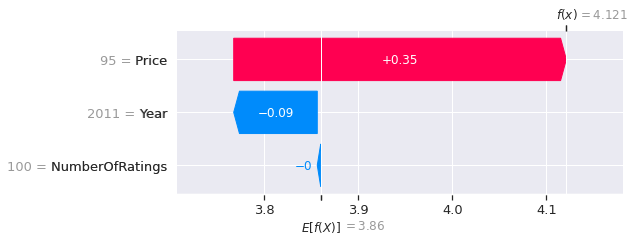

In [ ]:

# Import the SHAP library
import shap

# Create the explainer object and compute the SHAP explanation values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

sns.set()
shap.plots.waterfall(shap_values[datum_id])



The above figure is called a *SHAP waterfall plot*.

Starting from the average model prediction ($3.86$ - you can check this with `np.average(model.predict(X))`), it shows the SHAP value for each feature adjusting the model's prediction away from the average, until arriving at the actual prediction for this wine ($4.12$).

SHAP values which increase the model's prediction above the average prediction are in *RED*, and SHAP values which decrease the model's prediction below the average prediciton are in *BLUE*.

You read the graph from bottom to top, which corresponds to starting at the average model prediciton and working through features in increasing order of importance to get to the actual model prediction.

So, starting from the bottom bar, we can see that for the *Pomerol 2011* vintage,

 1. The number of ratings ($=100$) had **negligible negative effect**, bumping the prediction from $3.86$ down to about $3.85$
 2. The year ($=2011$) had a **moderate negative effect**, moving the prediction from about $3.85$ down to about $3.79$, and
 3. The price ($=\$95$) had a **large positive effect**, increasing the prediction from $3.79$ to the actual model prediciton of $4.12$.



Let's look at a different datum, the *Cuvée Confidence Côtes du Rhône Rouge 2017* (datum ID 14).


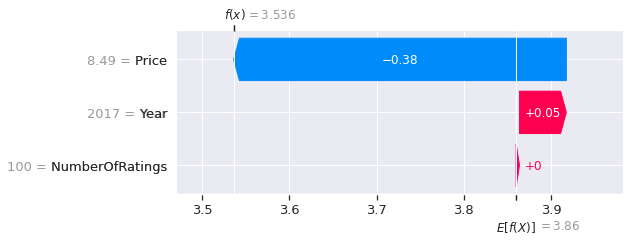

In [ ]:

other_datum_id = 14

shap.plots.waterfall(shap_values[other_datum_id])



In this case, the relative importance of each feature is the same (number of ratings has almost no effect, year has a moderate effect, and price has a massive effect), but the sign of the effects is different!

 1. Number of ratings ($100$ again) had a **negligible positive effect**
 2. Year ($2017$) had a **small positive** effect
 3. Price ($8.49$) had a **large negative** effect

Note that a feature can take the same value for different data (e.g. 100 ratings is the same for the two different vintages) but have a different SHAP value!



# Pause and ponder

 * Do the SHAP 'explanations' align with your understanding of how Red wine vintages are rated by wine connisuers?

 * Are SHAP 'explanations' useful for understanding the model's behaviour? What about for explaining how the model works?

 * What kind of stakeholders are SHAP explanations best suited for?




# Some more detail

SHAP is classified as a local, model-agnostic XAI method. However, there are  caveats to both points.

The local SHAP explanations for every data point can be visualised in bulk to get an idea of  the overall behaviour of the model. Similarly, although the theoretical grounding of SHAP is model-agnostic, for computational and practical reasons, model-specific approximations to true SHAP values are often used.

To illustrate using SHAP for 'global explanation', below we average the magnitude of the SHAP values for all features across the data to get an idea of how important that feature is in general.


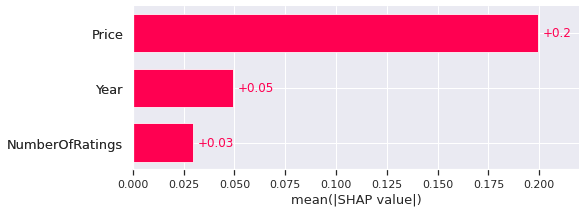

In [ ]:

shap.plots.bar(shap_values)



In general, price has the biggest impact on the model's predictions, while number of ratings has the smallest impact. Note that this visualisation doesn't say anything about the type of impact (positive or negative).



We can go further and use a *SHAP Bee Swarm plot* to show this model's SHAP explanation values for the entire dataset at once.

This can give us a more detailed picture of each feature's relative importance, including type of impact (positive or negative)


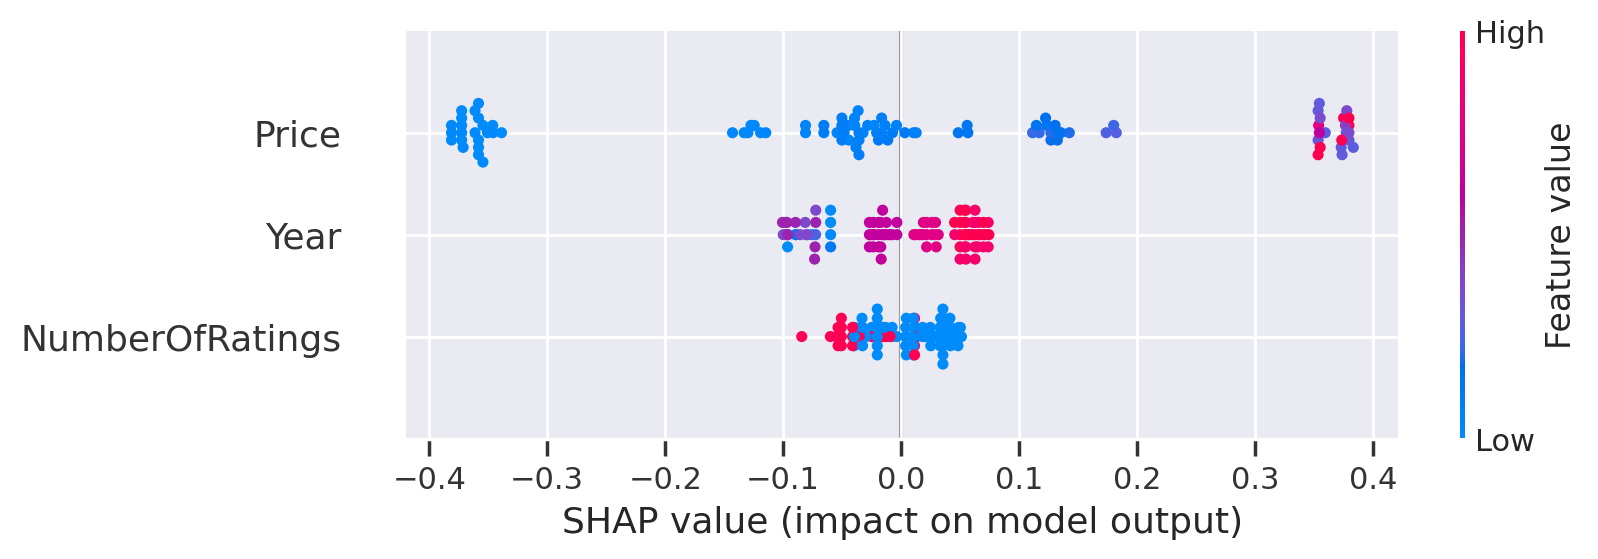

In [ ]:

plt.figure(figsize=(6, 2), dpi=200)
shap.plots.beeswarm(shap_values)



In this plot, each dot is a SHAP value for one feature for one prediction.

Dots that are more *red* indiciate that the feature had a larger positive value, while dots that more *blue* indicate that the feature had a larger negative value.

Dots further to the *right* indicate that the SHAP value for that prediction had a positive value (the feature the model's prediction), while dots further to the *left* indicate that the SHAP value for that prediction had a negative value (the feature decreased the model's prediction).

Note that because these visualisations are based on the dataset, they aren't *really* explaining the global behaviour of the model. They are more a kind of visualisation of the average behaviour of the model with respect to our datset.


## An explanation of Shapley Values

What exactly is a Shapley value?

Let's consider an example (warning, some math is involved below).

> Three friends Alice, Bob, and Carol, work together to make some lemonade. The friends are able to sell their lemonade for a total of $100 (it's *really* nice lemonade). How much money should each person get?

A simple answer might be to split the money evenly, but this might not be fair if each person did a different amount of work. Maybe Bob is actually a clutz and Alice and Carol could have earned more without his help!

Shapley values consider all the possible alternate teamwork scenarios (and the corresponding amount of money that would have been made in each case) to compute a 'fair' allocation of reward.

In our lemonade example, we would get Alice, Bob, and Carol to try working in different teams, and measure how much money each team makes. We can then calculate the contribution that Alice, Bob, and Carol make to each team.

| Team              | Total $ Earned | Alice's contribution | Bob's contribution | Carol's contribution |
|-------------------|---------------:|---------------------:|-------------------:|---------------------:|
| Just Alice        |             40 |                   40 |                  - |                    - |
| Just Bob          |             30 |                    - |                 30 |                    - |
| Just Carol        |             50 |                    - |                  - |                   50 |
|-------------------|-------------------|-------------------|-------------------|-------------------|
| Alice + Bob       |             60 |         60 - 30 = 30 |       60 - 40 = 20 |                    - |
| Alice + Carol     |             80 |         80 - 50 = 30 |                  - |         80 - 40 = 40 |
| Bob + Carol       |             50 |                    - |        50 - 50 = 0 |         50 - 30 = 20 |
|-------------------|-------------------|-------------------|-------------------|-------------------|
| Everyone together |            100 |        100 - 50 = 50 |      100 - 80 = 20 |        100 - 60 = 40 |

The Shapley value for each person is then given by their **average contribution across the different team sizes**.

For instance, looking at Bob's contributions;

 * When Bob was in a team of just one person, Bob's contribution was $\$30$
 * When Bob was in a team of two people, Bob's average contributions was $(\$20 + \$0) / 2 = \$10$
 * When Bob was in the team of three people, Bob's contribution was $\$20$

Bob's Shapley value is the average of his average contributions for each team size: $(\$30 + \$10 + \$20) / 3 = \$20$

The Shapley values for everyone are;

 * Alice: $(\$40 + \$30 + \$50) / 3 = \$40$
 * Bob: $(\$30 + \$10 + \$20) / 3 = \$20$
 * Carol: $(\$50 + \$30 + \$40) / 3 = \$40$

Notice that adding everone's Shapley values up, we get the total amount that they actually earned when they all worked together $(\$40 + \$20 + \$40 = \$100)$. This additive property lets us interpret the Shapley value as how much each person's effort 'contributed' to earning the total revenue.



## The connection to Machine Learning explanation

Lemonade is well and good, but how does this relate to explaining the predictions of a machine learning model?

 * In SHAP, the *features* of a machine learning dataset correspond to the *people* working together (Alice/Bob/Carol).

 * The features 'collaborate' to produce a *numeric prediction*, which corresponds to the *total earnings* ($\$100$).

 * Looking at different *sub-sets of features* corresponds to the different *team combinations*  (just Alice, Alice and Bob, Everyone working together, etc.).

There is a little more math invovled, but once it is all put together, **SHAP values measure how much a dataset feature contributed to model's prediction being different from the average model prediction.**


## Some other mathematical points

You might also be wondering; "What does it mean when we say that Shapley values try to allocate rewards to parties 'fairly'"?

This means that Shapley values satisfy two$^1$ mathematical principles;

 1. **Efficiency**: The Shapley values for all features must add up to the whole difference between the model's prediction and the average prediction.

 2. **Monotonicity**: If feature A consistently contributes more to the prediction than feature B under all possible feature combinations, then it should have a larger Shapley value.

Shapley values are a unique mathematical solution to the problem of distributing the total 'reward' in a cooperative game, while still satisfying these principles.

$^1$Shapley values were originally defined in terms of four principles; (i) Completeness/Efficiency, (ii) Symmetry, (iii) Dummy property, and (iv) Linearity/Additivity, however subsequent analyses [2] have shown that in the Machine Learning context, the Efficiency and Monotonicity principles are equivalent.



Extension activity: read sections [9.6.10 and 9.6.11 'Advantages and Disadvantages of SHAP explanations'](https://christophm.github.io/interpretable-ml-book/shap.html#advantages-17) from the Interpretable Machine Learning Book and reflect on what this means for when and where you might use SHAP explanations.



# References

[1] Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Advances in neural information processing systems 30 (2017).

[2] H Peyton Young. "Monotonic solutions of cooperative games". In: International Journal of Game Theory 14.2 (1985), pp. 65–72.

---

This tutorial is adapted from content at [h2o.ai](https://h2o.ai/blog/shapley-values-a-gentle-introduction/), [Oliver Caelen at Medium](https://medium.com/the-modern-scientist), and [Christoph M's Interpretable ML Book](https://christophm.github.io/interpretable-ml-book/shap.html).